In [1]:
#Скачаем репозиторий проекта lime_imag и установим lime
!git clone https://github.com/marcotcr/lime.git
!pip install lime

fatal: destination path 'lime' already exists and is not an empty directory.



[notice] A new release of pip available: 22.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

In [21]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
mnist_data = mnist.data.values.astype(np.uint8)
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist_data.reshape((-1, 28, 28))], 0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

Text(0.5, 1.0, 'Digit: 5')

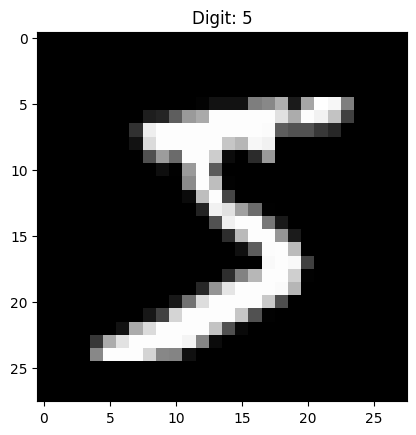

In [22]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

# Настройка конвейера
Здесь мы создаем конвейер для обработки изображений, где, по сути, сплющиваем изображение в 1d-векторы, а затем используем классификатор RandomForest.

In [23]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Обертка для превращения функций в конвейерные преобразования (без подгонки)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)

In [25]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x000001F596104A30>),
                ('Flatten Image',
                 <__main__.PipeStep object at 0x000001F596104790>),
                ('RF', RandomForestClassifier())])

In [26]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # добавить текущую директорию
    import lime

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [28]:
%%time
explanation = explainer.explain_instance(X_test[0],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 10.3 s
Wall time: 10.2 s


Text(0.5, 1.0, 'Положительные/отрицательные регионы для 5')

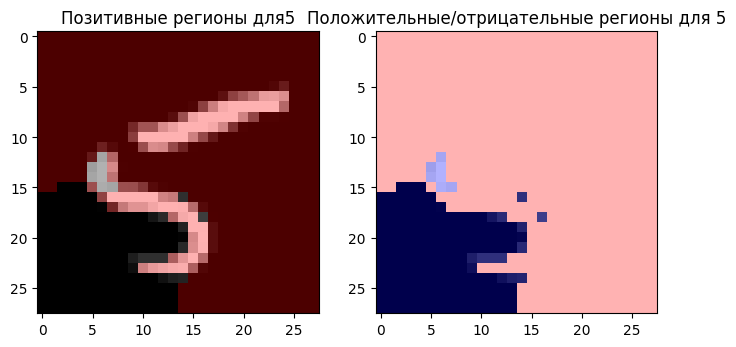

In [29]:
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=True, num_features=10, hide_rest=False, min_weight=0.01)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Позитивные регионы для{}'.format(y_test.iloc[0]))

temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=False, num_features=10, hide_rest=False, min_weight=0.01)
ax2.imshow(label2rgb(3 - mask, temp, bg_label=0), interpolation='nearest')
ax2.set_title('Положительные/отрицательные регионы для {}'.format(y_test.iloc[0]))

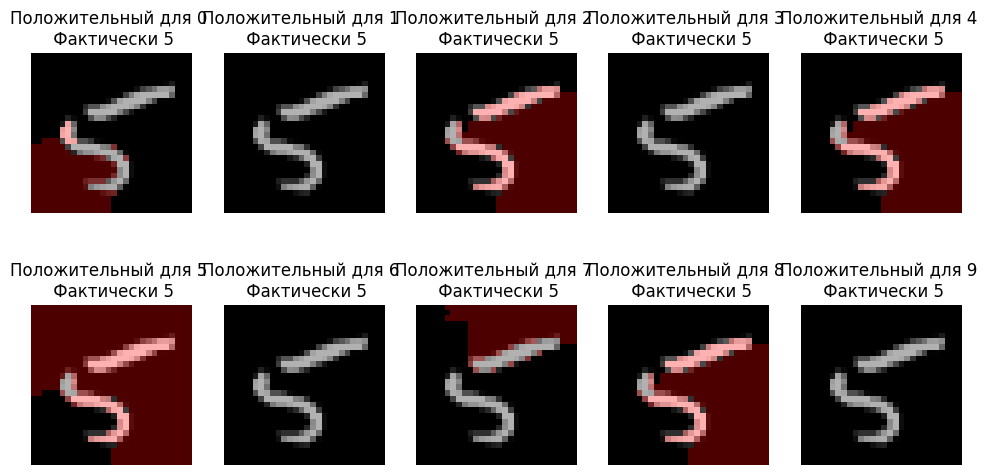

In [30]:
# now show them for each class
fig, m_axs = plt.subplots(2, 5, figsize=(12, 6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask, X_test[0], bg_label=0), interpolation='nearest')
    c_ax.set_title('Положительный для {} \n Фактически {}'.format(i, y_test.iloc[0]))
    c_ax.axis('off')

# Получение понимания
Можно ли найти объяснение классификации, в которой алгоритм ошибся.

In [31]:
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Используя #{}, где метка была {}, а конвейер предсказал {}'.format(wrong_idx, y_test.iloc[wrong_idx], pipe_pred_test[wrong_idx]))

Используя #9691, где метка была 9, а конвейер предсказал 4


In [32]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: total: 10.5 s
Wall time: 10.5 s


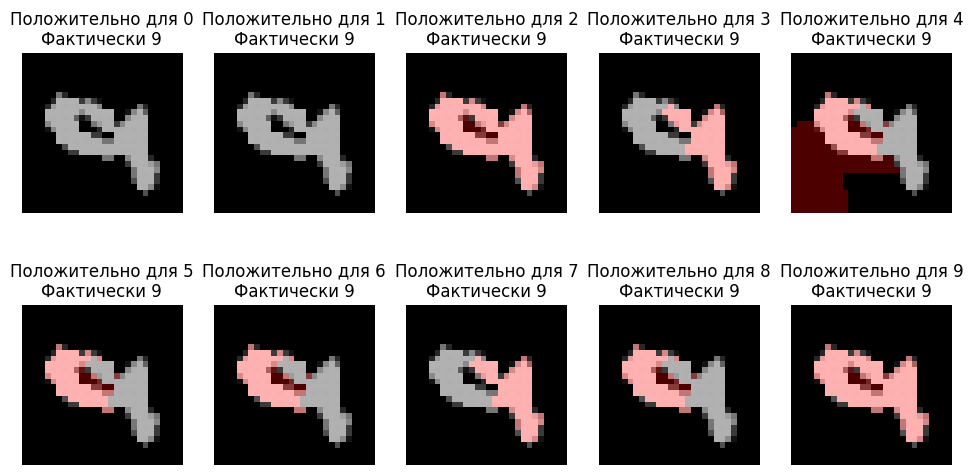

In [33]:
# now show them for each class
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Положительно для {}\nФактически {}'.format(i, y_test.iloc[wrong_idx]))
    c_ax.axis('off')